In [1]:
import numpy as np
# import my_torchbox as tb
import parseBrats as pB
import matplotlib.pyplot as plt
import skimage
from scipy.ndimage import binary_dilation
# TDA
import persim
import cripser

%load_ext autoreload
%autoreload 2
from misc import *
import segmentation_TDA as sTDA
import  stickEdges as sE

# Open images.

BratS lint is 1251 long
>> BraTS2021_01111
BraTS name : BraTS2021_01111


Text(250, 225, 'T1ce')

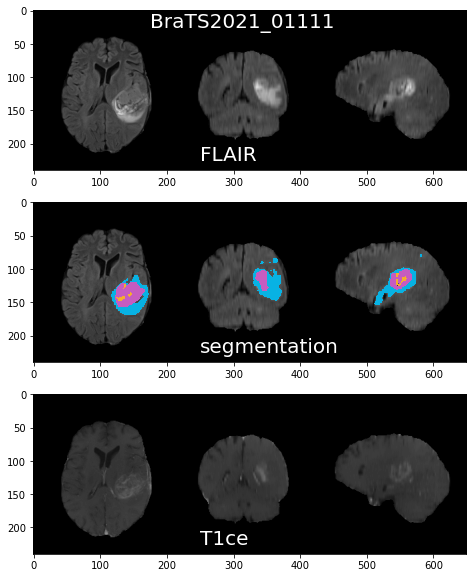

In [3]:
# You can select one or more file by putting them into brats_list
# Or set to None to choose randomly from the whole data set.
brats_list = None

# brats_list = ["BraTS2021_01053","BraTS2021_01143","BraTS2021_01121","BraTS2021_00318",'BraTS2021_01296','BraTS2021_00636','BraTS2021_00557','BraTS2021_01245','BraTS2021_00113']
pb = pB.parse_brats(brats_list=brats_list,
                    brats_folder='2021',
                    modality='flair',
                    get_template=False)
print(f"BratS lint is {len(pb.brats_list)} long")

# i = 1
i = np.random.randint(len(pb.brats_list))
brats_name = pb.brats_list[i]
print('>>',brats_name)

img_flair,seg_true, = pb(i,to_torch=False,modality='flair',normalize=True)
img_t1ce,_, = pb(i,to_torch=False,modality='t1ce')
# img_t2,_, = pb(i,to_torch=False,modality='t2')
# img_t1,_, = pb(i,to_torch=False,modality='t1')

seg_union_true = seg_true.copy()
seg_union_true[seg_true > 0] =1
print(f"BraTS name : {pb.brats_list[i]}")
sigma= 1
img_flair_b = scipynd.gaussian_filter(img_flair, sigma=sigma)
pos= sTDA.argmax_image(img_flair_b)

fig,ax = plt.subplots(3,1,figsize=(12,10))
ax[0].imshow(make_3d_flat(img_flair,pos ),cmap='gray',vmax=1)
ax[0].text(175,25,pb.brats_list[i],c='white',fontsize=20)
ax[0].text(250,225,'FLAIR',c='white',fontsize=20)
ax[1].imshow(make_3d_flat(img_flair,pos ),cmap='gray',vmax=1)
ax[1].text(250,225,'segmentation',c='white',fontsize=20)
ax[1].imshow(make_3d_flat(seg_true,pos),**DLT_KW_SEG)
ax[2].imshow(make_3d_flat(img_t1ce,pos ),cmap='gray',vmax=1)
ax[2].text(250,225,'T1ce',c='white',fontsize=20)

# Step 1 : Union segmentation:

suggest_t : Compute curve... 

Computation of suggest_t done in  0:00:00s and 0.322cents  s
There are 174818 labels


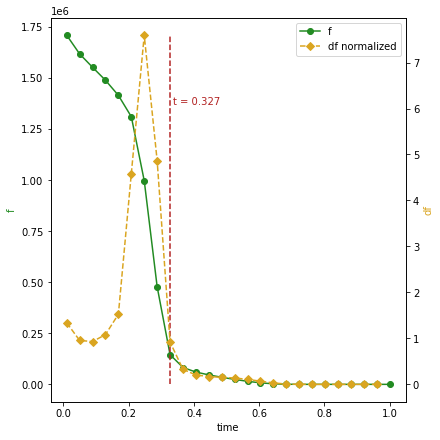

In [4]:
t,_,_,_ = sTDA.suggest_t(img_flair_b, dt_threshold=1, verbose=True, plot=True)

# Extract
seg_union = sTDA.get_largest_CC(img_flair, t, verbose=True)

## Fill holes

In [5]:
seg_remaining = (seg_union>0)*1-1
seg_remaining[seg_remaining<0]=1
labels = skimage.measure.label(seg_remaining, background=0) #scipy.ndimage.label(seg_union_nocontour)
components = [(labels==i)*1 for i in range(1,np.max(labels))]

print('Number of remaining components:', len(components))

if len(components)>0:
    components_cardinal = [np.sum(component) for component in components]
    cardinalmax = max(components_cardinal)
    remainingcomponents = np.sum([components[i] for i in range(len(components)) if components_cardinal[i]<cardinalmax],0)
    seg_union[remainingcomponents>0] = 1

Number of remaining components: 35


## Stick to edges

size difference : 0.7961823595539756 1.2559936652706094


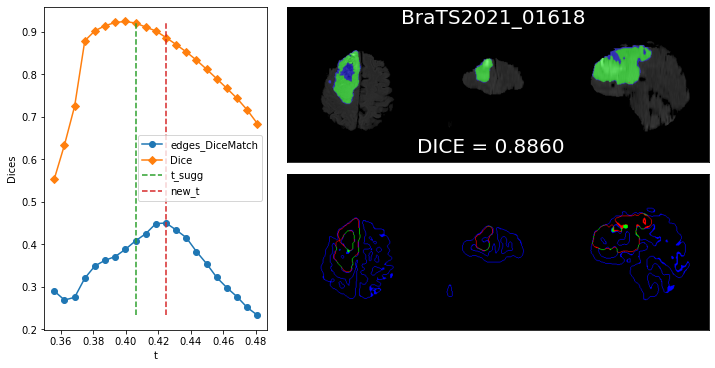

In [5]:
pos_sugg_t = sTDA.argmax_image(seg_union * img_flair_b)
new_seg = sE.plot_respectEdges(img_flair,seg_union_true,t,pos_sugg_t,brats_name=pb.brats_list[i],n_test=21,ovrlap=.05)

print('size difference :',new_seg.sum()/seg_union_true.sum(),seg_union_true.sum()/new_seg.sum())

## plot union segmentation

suggest_t : Compute curve... 

Computation of suggest_t done in  0:00:00s and 0.324cents  s
Dice 0.7118050437626778, DiceEdges = 0.2694762747058371
[0 1]


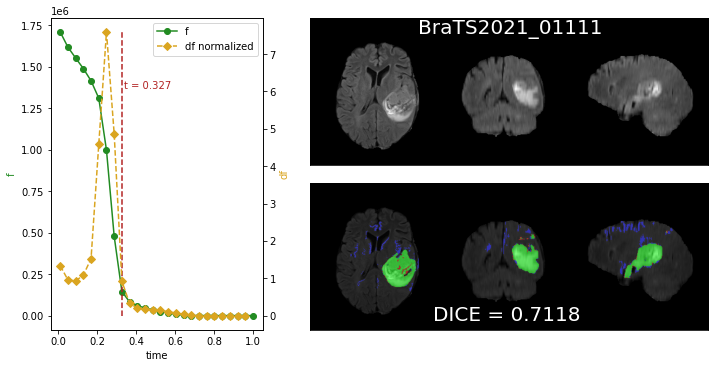

In [6]:
fig, axs = plt.subplots(2,2,
                            figsize = (10,5),
                            gridspec_kw={'width_ratios': [1, 2]},
                            constrained_layout=True)
gs = axs[0, 0].get_gridspec()
# remove the underlying axes
axs[0,0].remove()
axs[1,0].remove()
axbig = fig.add_subplot(gs[:, 0])

# 1st step: find segmentation union
# Find best t
_ = sTDA.suggest_t(img_flair_b, dt_threshold=1, verbose=True, plot=True,ax=axbig)

print(f"Dice {DICE(seg_union,seg_union_true)}, DiceEdges = {edges_DiceMatch(img_flair_b,seg_union)}")


axs[0,1].imshow(make_3d_flat(img_flair,pos ),cmap='gray')
# axs[0,1].imshow(make_3d_flat(seg_true, pos),cmap='gray')
# plotMask(make_3d_flat(seg_union,pos),make_3d_flat(img_flair,pos),axs=axs[0,1], origin='upper')
axs[0,1].text(175,25,pb.brats_list[i],c='white',fontsize=20)
axs[1,1].imshow(make_3d_flat(img_flair,pos ),cmap='gray')
axs[1,1].imshow(
    imCmp(
        make_3d_flat(seg_union_true, pos),
        make_3d_flat(seg_union, pos),
        method='seg'
    ),alpha=0.5
)
axs[1,1].text(200,225,f"DICE = {DICE(seg_union,seg_union_true):.4f}",c='white',fontsize=20)
set_ticks_off(axs[0,1])
set_ticks_off(axs[1,1])
print(np.unique(seg_union))
plt.show()

# Step 2 : ET Identification


There are 13162 bars.


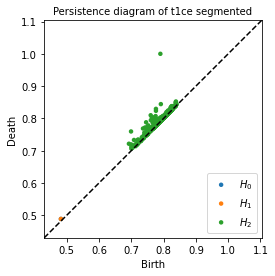

In [8]:
seg_union_t1ce = img_t1ce*seg_union
# Compute persitence diagram
barcode = cripser.computePH(1-seg_union_t1ce,maxdim=3)
# Only non-infinite bars
H2 = [list(bar[1::]) for bar in barcode if bar[0]==2 and bar[2]<1]
 # Sort list H2 by persistence
H2 = [bar for _,bar in sorted(zip([bar[1]-bar[0] for bar in H2],H2))[::-1]]

print('There are '+repr(len(barcode))+' bars.')

# Plot diagram
if len(H2)>0:
    fig, ax = plt.subplots(1,1, figsize=(4,4))
    persim.plot_diagrams([np.array([barcode[0][1:3]]), np.array([barcode[0][1:3]]), np.array([bar[1:3] for bar in barcode if bar[0]==3-1])])
    plt.title('Persistence diagram of t1ce segmented',fontsize=10)
else:
    print('H2 is empty!')



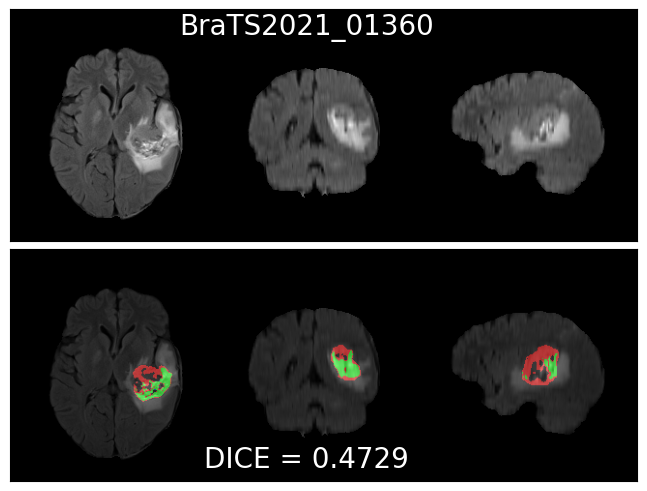

In [9]:
# Extract contour H2
i = 0
if len(H2)<=i:
    seg_contour = 0*seg_union_t1ce
else:
    bar = H2[i]
    pos = np.array(bar[2:5]).astype(int)
    t = bar[0]+0.0001
    seg_contour = sTDA.getConnectedComponent(seg_union_t1ce, pos, 1-t)

# ============== PLOT ==============

seg_contour_true = np.zeros(seg_true.shape)
seg_contour_true[seg_true == 4] = 1

fig,ax = plt.subplots(2,1,constrained_layout=True)
ax[0].imshow(make_3d_flat(img_flair,pos ),cmap='gray')
ax[0].text(175,25,pb.brats_list[i],c='white',fontsize=20)
ax[1].imshow(make_3d_flat(img_flair,pos ),cmap='gray')
ax[1].imshow(
    imCmp(
        make_3d_flat(seg_contour_true, pos),
        make_3d_flat(seg_contour, pos),
        method='seg'
    ),alpha=0.5
)
ax[1].text(200,225,f"DICE = {DICE(seg_contour,seg_contour_true):.4f}",c='white',fontsize=20)
set_ticks_off(ax)
plt.show()

# Step 3: identification of TC and WT

At this point, we have estimated the segmentation of the global tumour, $X$, and the en-
hancing tumour $X_{\mathrm{ET}}$ . We now identify the components $X_{\mathrm{TC}}$ and $X_{\mathrm{WT}}$ . This step does not
depends on the initial MRI, but only on the subsets $X$ and $X_{\mathrm{ET}}$ .

Following our model, $\mathrm{TC}$ corresponds to the part of the tumour that lies inside $\mathrm{ET}$, and
$\mathrm{WT}$ to the part that lies outside $\mathrm{ET}$ (and still within $X$). In order to identify these parts,
we apply the following procedure.


Segmentation color code
    1. - BLUE,   TC -> NECROSE INACTIVE, TUMORUS CORE
    2. - ORANGE, WT -> INFILTRATION, OEDEME, WHOLE TUMOR
    4. - RED,    ET -> NECROSE ACTIVE, ENHENCING TUMOR


In [10]:
seg_union_nocontour = seg_union - seg_contour
seg_nocontour_components = []
labels = skimage.measure.label(seg_union_nocontour, background=0)

N = 10 # select components with cardinal at least N
components = [(labels==i)*1 for i in range(1,np.max(labels))]
components = [component for component in components if np.sum(component)>N]
print('There are', len(components), 'components')

# Classify components: TC or WT
seg_final = seg_contour*4 # define seg_final
for component in components:
    component_dilated = binary_dilation(component, iterations=1)
    component_contour = component_dilated - component
    meanvalue = np.mean(seg_contour[np.where(component_contour > 0)])
    if meanvalue<1/2: #sort segmentation mask, label 2
        seg_final[component>0] = 2
    else: #label 1
        seg_final[component>0] = 1

# Fill the holes as they were TC
seg_remaining = (seg_final>0)*1-1
seg_remaining[seg_remaining<0]=1
labels = skimage.measure.label(seg_remaining, background=0)
components = [(labels==i)*1 for i in range(1,np.max(labels))]
print('Number of remaining components:', len(components))

if len(components)>0:
    components_cardinal = [np.sum(component) for component in components]
    cardinalmax = max(components_cardinal)
    remaining_components = np.sum(
        [
            components[i]
            for i in range(len(components))
            if components_cardinal[i]<cardinalmax
        ]
        ,0)
    seg_final[remaining_components>0] = 1


There are 3 components
Number of remaining components: 2


Well labeled pixels 75655, proportion in image 0.6946880308525779
mislabeled pixels: 33250
Baddly segmented pixels 74628


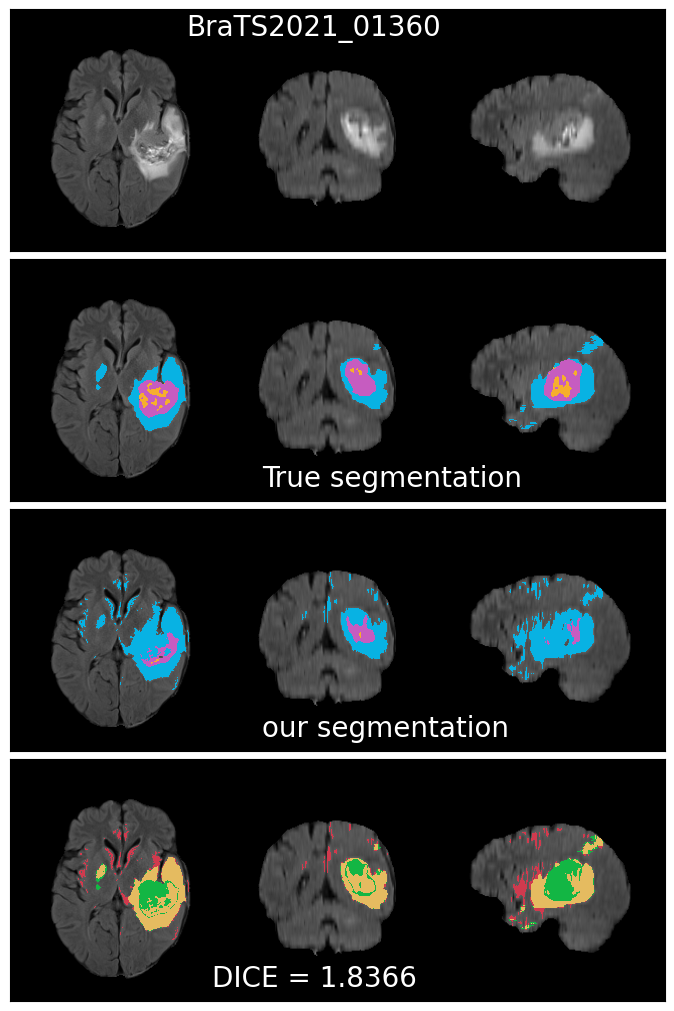

In [11]:
# ============== PLOT ==============
from math import  prod

seg_contour_true = np.zeros(seg_true.shape)
seg_contour_true[seg_true == 4] = 1

fig,ax = plt.subplots(4,1,constrained_layout=True,figsize=(8,10))
ax[0].imshow(make_3d_flat(img_flair,pos ),cmap='gray')
ax[0].text(175,25,pb.brats_list[i],c='white',fontsize=20)

ax[1].imshow(make_3d_flat(img_flair,pos ),cmap='gray')
ax[1].imshow(make_3d_flat(seg_true,pos),**DLT_KW_SEG)
ax[1].text(250,225,'True segmentation',c='white',fontsize=20)

ax[2].imshow(make_3d_flat(img_flair,pos ),cmap='gray')
ax[2].imshow(make_3d_flat(seg_final,pos),**DLT_KW_SEG)
ax[2].text(250,225,'our segmentation',c='white',fontsize=20)

seg_superpose = np.zeros(seg_true.shape)
# Good segmentation => Green
good_bool = np.logical_and(
        (seg_true == seg_final),
        (seg_true + seg_final != 0)
    )
seg_superpose[good_bool] = 3
print(f"Well labeled pixels {good_bool.sum()}, proportion in image {good_bool.sum()/(seg_true>0).sum()}")

# It is part of the tumour but mislabeled => Orange
mislabeled_bool = np.logical_and(
        (seg_true != seg_final),
        (seg_true  >= 1),
        (seg_final >= 1)
     )
seg_superpose[mislabeled_bool]= 2
print(f"mislabeled pixels: {mislabeled_bool.sum()}")

# Not part of the tumour => Red
misseg_bool =  np.logical_and(
        (seg_true != seg_final),
        (seg_true  == 0)
     )
seg_superpose[misseg_bool]= 1
print(f"Baddly segmented pixels {misseg_bool.sum()}")

cmap_cmp_segs = ListedColormap(
    [[0,0,0,0],
     '#D03A4E', # Rusty red
     '#13B644', # Dark pastel green
     '#E5BB60', # Gold
     ])
ax[3].imshow(make_3d_flat(img_flair,pos ),cmap='gray')
ax[3].imshow(make_3d_flat(seg_superpose,pos),cmap=cmap_cmp_segs,interpolation='nearest')

# ax[3].imshow(
#     imCmp(
#         make_3d_flat(seg_true, pos)/4,
#         make_3d_flat(seg_final, pos)/4,
#         method='seg'
#     ),alpha=0.5
# )
ax[3].text(200,225,f"DICE = {DICE(seg_final,seg_true):.4f}",c='white',fontsize=20)
set_ticks_off(ax)
plt.show()